# 데이터와 예측 비교하기

이전 [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/train_simple_model.ipynb)에서, 간단한 모델을 훈련하고 정확도, 정밀도, 재현율, f1-점수를 확인했습니다. 이런 지표는 좋지만 모델의 성능과 단점에 대한 깊은 이해를 얻고 싶습니다.

이렇게 하기 위해 먼저 오차 행렬을 살펴 보고, 그다음 ROC 커브, 마지막으로 보정 곡선을 알아 보겠습니다.

먼저 데이터를 로드합니다.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    add_text_features_to_df,
    get_vectorized_series,
    get_feature_vector_and_label,
)
from ml_editor.model_evaluation import get_confusion_matrix_plot, get_roc_plot, get_calibration_plot

data_path = Path('data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


그다음 특성을 추가하고 데이터셋을 분할합니다.

In [8]:
df = add_text_features_to_df(df.loc[df["is_question"]].copy())
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

훈련된 모델과 벡터화 객체를 로드합니다.

In [9]:
model_path = Path("models/model_1.pkl")
clf = joblib.load(model_path)
vectorizer_path = Path("models/vectorizer_1.pkl")
vectorizer = joblib.load(vectorizer_path)

벡터화 객체를 사용해 데이터에서 모델에 필요한 특성을 만듭니다.

In [10]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer)

features = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]
X_train, y_train = get_feature_vector_and_label(train_df, features)
X_test, y_test = get_feature_vector_and_label(test_df, features)

마지막으로 테스트 세트에서 모델의 예측을 계산합니다.

In [11]:
y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

## 오차 행렬

가장 먼저 오차 행렬을 그려 보겠습니다. 오차 행렬은 모델이 잘 동작하는 클래스를 한 눈에 확인하는데 편리합니다.

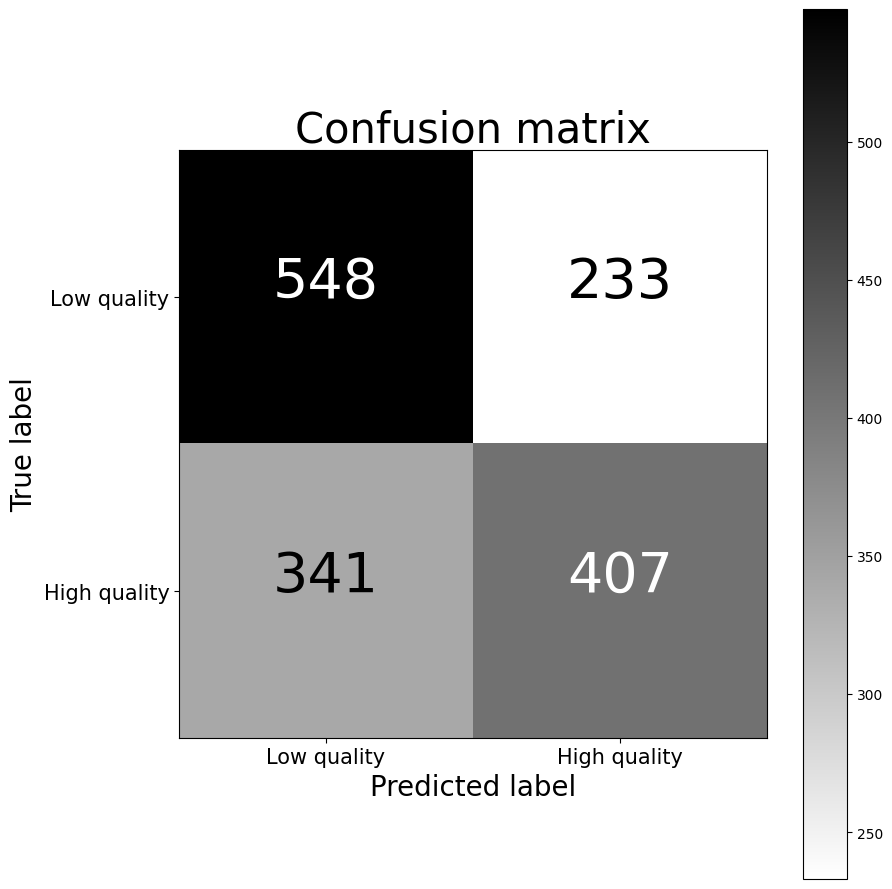

In [12]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))
plt.show()

이 오차 행렬을 보면 낮은 점수의 질문을 예측하는데 모델이 잘 동작하는 것 같습니다(낮은 점수의 질문에 대해서는 재현율이 높습니다):

- 낮은 점수의 질문을 올바르게 예측한 비율: 548/(548+233) = 68%
- 높은 점수의 질문을 올바르게 예측한 비율: 407/(407+341) = 53%

## ROC 곡선

그다음 ROC 곡선을 그려 보겠습니다. 이 함수는 모델의 진짜 양성 비율을 거짓 양성 비율의 함수로 보여줍니다.

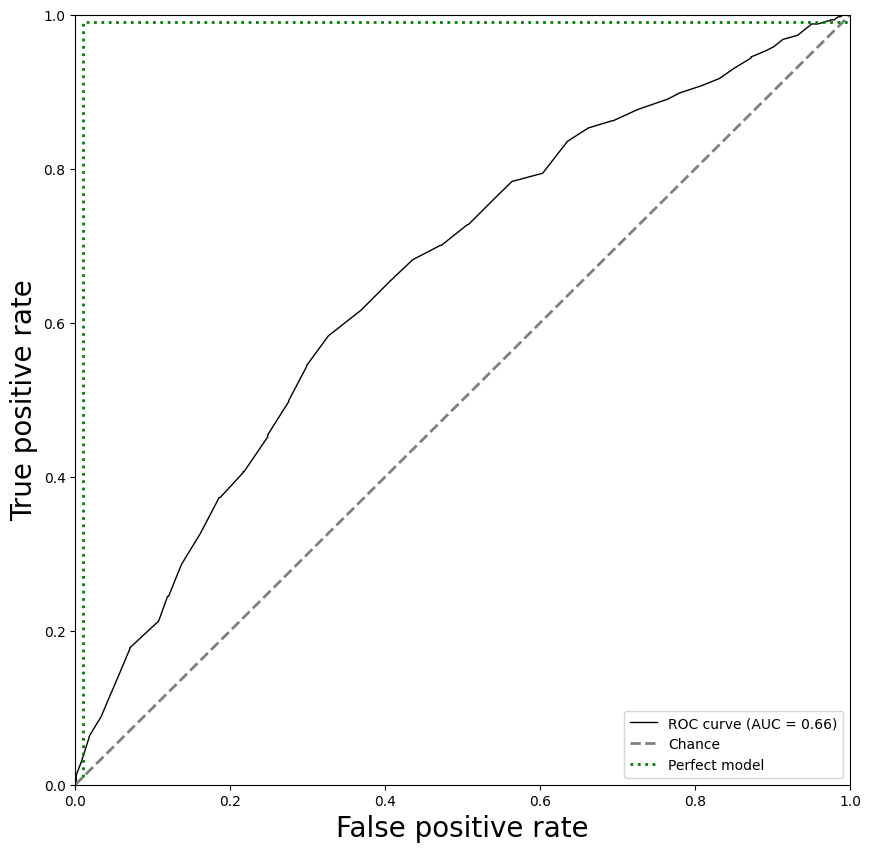

In [13]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))
plt.savefig('images/bmlpa_figures/ch05-7.png', dpi=300)
plt.show()

ROC 곡선은 모델의 전반적인 성능을 판단하는데 도움이 됩니다. 하지만 대부분의 모델은 실용적인 애플리케이션을 염두에 두고 설계됩니다.
이런 애플리케이션은 거짓 양성이 특정 비율 아래로 유지되는 것 같이 특정 성능 요구사항이 종종 뒤따릅니다.
모델의 성능을 더 잘 이해하려면 아래 그림처럼 ROC 곡선의 관련 부분을 시각적으로 부각시키면 도움이 됩니다.

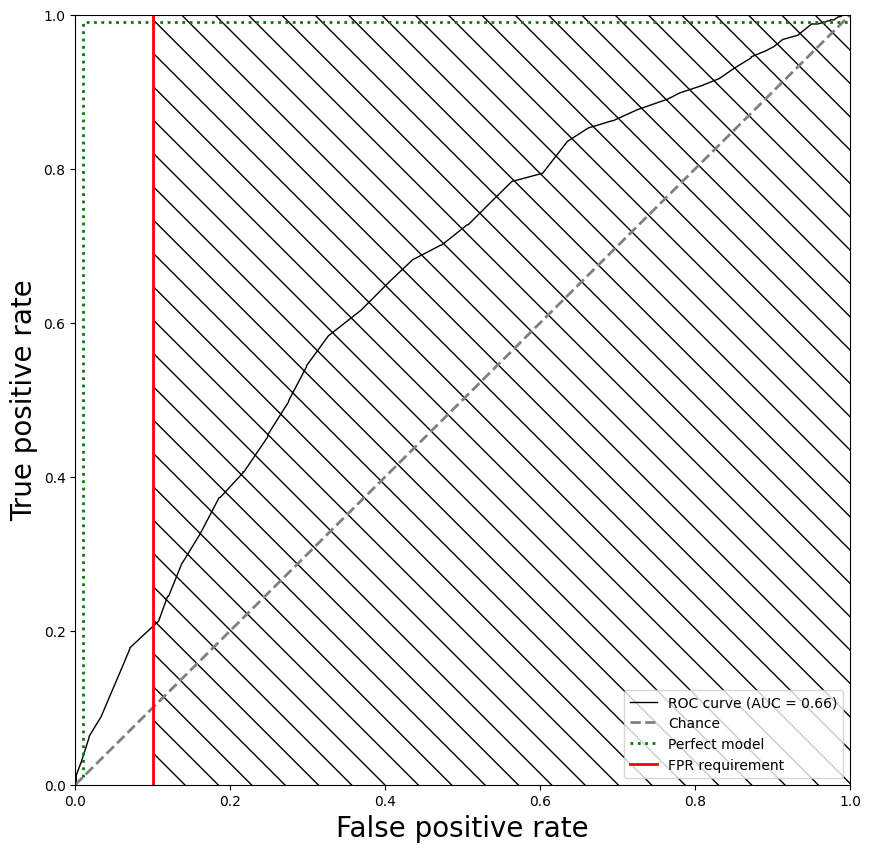

In [14]:
get_roc_plot(y_predicted_proba[:,1], y_test, fpr_bar=.1, figsize=(10,10))
plt.savefig('images/bmlpa_figures/ch05-8.png', dpi=300)
plt.show()

선택한 FPR 요구사항 `.1`에서 모델은 `.2` 진짜 양성 비율 근방에 도달했습니다.
이 FPR 제약을 관리하는 것이 중요한 애플리케이션에서 이어지는 실험에서 추적해야 할 지표입니다.

## 보정 곡선

마지막으로 보정 곡선을 그려 보겠습니다. 실제 양성 샘플의 일부를 모델의 확률 점수의 함수로 그립니다. 이런 곡선을 사용하면 모델의 확률 추정의 품질을 평가할 수 있습니다(모델이 `60%` 가능성으로 질문이 좋다고 말할 때 실제로 그런가요?)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.233


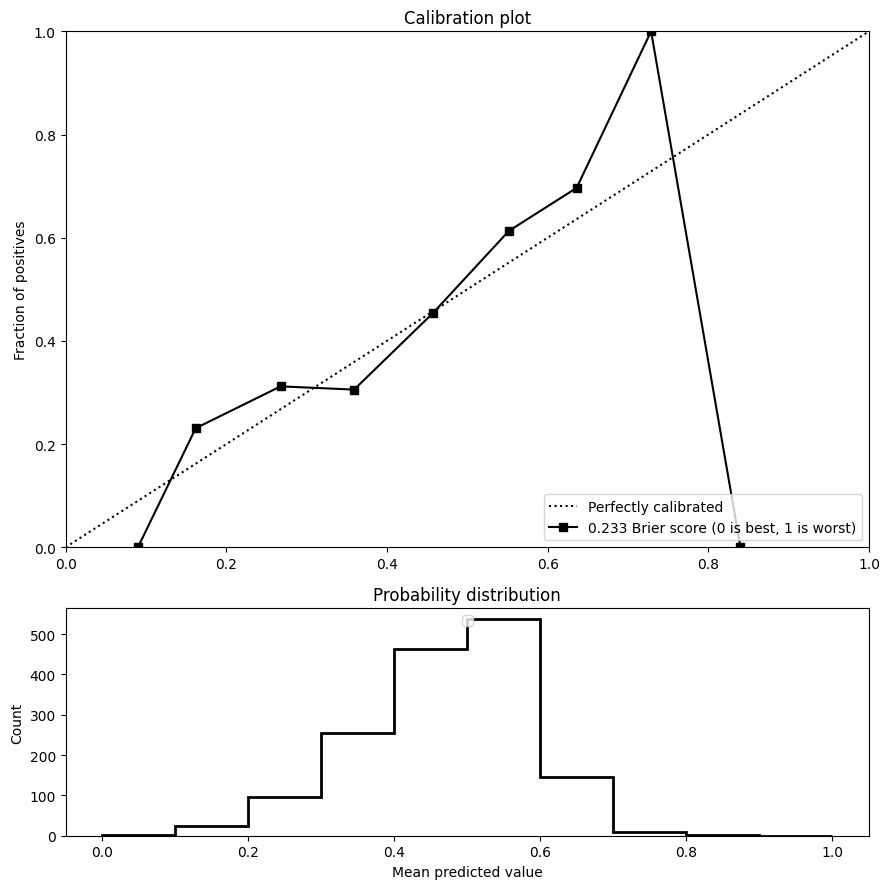

In [15]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))
plt.savefig('images/bmlpa_figures/ch05-9.png', dpi=300)

이 그래프에서 모델이 .2와 .7 사이에서 잘 보정되었고 그 밖에서는 나쁜 것을 볼 수 있습니다. 이는 부분적으로 모델이 대부분 .2와 .7 사이의 점수를 출력하기 사실 때문입니다. 그 아래 히스토그램에서 이를 볼 수 있습니다. 0~1 범위로 보정을 측정하는 [브라이어 점수](https://en.wikipedia.org/wiki/Brier_score)도 출력합니다. 0에 가까우면 완벽하게 보정된 모델입니다.

모델의 성공과 실패 사례를 더 잘 이해하고 싶다면 오류의 경향을 식별하기 위해 개별 샘플을 조사할 수 있습니다(탑 k [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/top_k.ipynb)에서 이렇게 하겠습니다). 그리고 훈련된 모델의 파라미터를 분석할 수 있습니다.